# # documentation of bitcoin analysis for prediction of future bitcoin prices

In [87]:
## import necessary packages
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.fft import fft, fftfreq

Begin by downloading bitcoin data by communicating with the coindesk API. The time period for the data is specified by inputting startdate and enddate into the relevent function in the format 'yyy-mm-dd'. The data is plotted for visualization purposes.

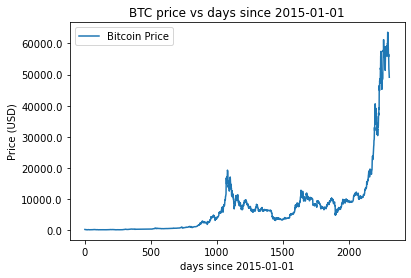

In [88]:

## functions
def get_data(startdate, enddate, fname):
    """
    gets bitcoin data from coindesk dating ffrom startdate to enddate, writes
    a json file with the data (bitcoin price and date) and returns a list of 
    days since startdate and a list of corresponding bitcoin prices
    """
    
    link = "https://api.coindesk.com/v1/bpi/historical/close.json?start={}&end={}".format(startdate, enddate)


    data = requests.get(link)
    data_json = data.json()

    ## functionality to write data to json file, commented out for online notebook
    #file = open(fname, 'w+')
    #file.write(json.dumps(data_json['bpi']))
    #file.close()

    btc_prices = list(data_json['bpi'].values())

    days = list(range(len(btc_prices)))

    return btc_prices, days

def read_data(fname):
    """
    reads bitcoin data from json file and returns list of bitcoin prices and 
    list of days corresonding to the prices
    """
    btc_dict = json.loads(fname)
    btc_prices = list(btc_dict.values())
    days = list(range(len(btc_prices)))
    
    return btc_prices, days


#filename to write data
fname_towrite = "BTC_data.json"

#link from which to get data
link = "https://api.coindesk.com/v1/bpi/historical/close.json?start=2015-01-01&end=2021-03-14"


#get data and plot
startdate, enddate = '2015-01-01', '2021-04-25'
prices, time = get_data(startdate, enddate, fname_towrite)

fig, ax = plt.subplots()

ax.plot(time, prices, label="Bitcoin Price")

ax.set_title('BTC price vs days since {}'.format(startdate))
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

The next step is to analyze the data by plotting it in different ways in an attempt to find a pattern in the dataset. 

The data appears to be exponential, so it is natural to plot the data with different types of logarithmic scaling. I will look at the data with log scaling on the y axis with base e and base 10, and look at the data with log scaling on both axis with base e and base 10.

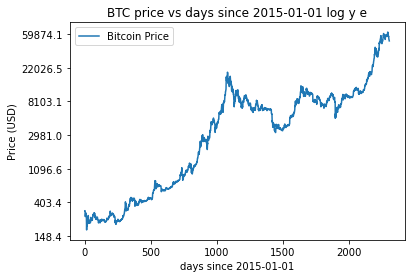

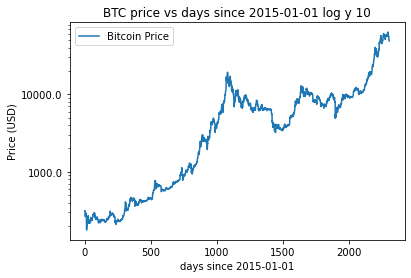

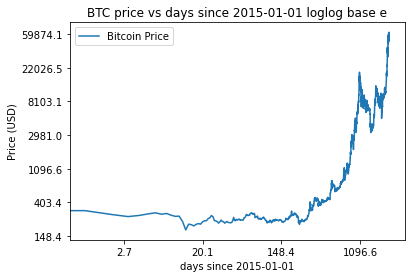

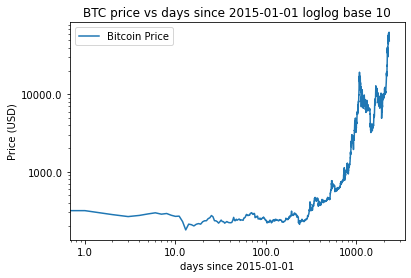

In [89]:

## y axis scaled by log base e 
fig, ax = plt.subplots()

ax.plot(time, prices, label="Bitcoin Price")

ax.set_title('BTC price vs days since {} log y e'.format(startdate))
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.set_yscale('log', basey = np.e)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()


## y axis scaled by log base 10
fig, ax = plt.subplots()

ax.plot(time, prices, label="Bitcoin Price")

ax.set_title('BTC price vs days since {} log y 10'.format(startdate))
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.set_yscale('log', basey = 10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()

## log-log scaling base e
fig, ax = plt.subplots()

ax.loglog(time, prices, label="Bitcoin Price", basey = np.e, basex = np.e)

ax.set_title('BTC price vs days since {} loglog base e'.format(startdate))
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()

## log-log scaling base 10
fig, ax = plt.subplots()

ax.loglog(time, prices, label="Bitcoin Price", basey = 10, basex = 10)

ax.set_title('BTC price vs days since {} loglog base 10'.format(startdate))
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()


# analysis

Log scaling on the y-axis makes the data more readable, however there are no obvious trends/patterns visible. Scaling in base e vs base 10 makes no difference in the readability of the data.

# next step

My next step will be to look at the second derivative of the price with respect to time. the second derivative will show the 'acceleration' of the bitcoin price, and show the time and strength of market 'forces' pushing the price up and down. in order to calculate a reasonable second derivative it will be necessary to smooth the price curve to cancel the noise from daily fluctuations in price. By doing this I will lose information about the short-term fluctuations, however this is not an issue because it is the long-term trends I am interested in.

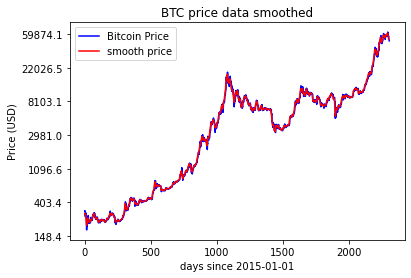

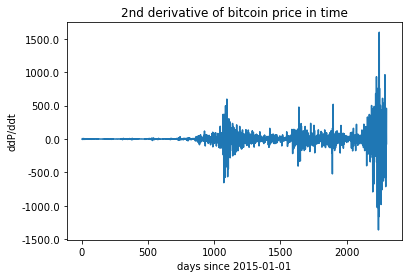

In [90]:


## functions
def smooth(xdata, avrange, minor_range = None):
    """
    creates a rolling average of the data in order to 'smooth' it to eliminate 
    fluctuations over shorter time periods. helpful for seeing general long
    term trends without short term noise
    """
    
    datasize = len(xdata)
    xavdata = [np.mean(xdata[(ind-avrange):(ind+avrange)]) for ind in range(datasize) 
               if ind >=avrange and ind <= datasize-avrange]
    avtime = list(range(len(xavdata)))
    
    if minor_range != None:
        xavdata = [np.mean(xdata[(ind-minor_range):(ind+minor_range)]) for ind in range(datasize) 
           if ind >=minor_range and ind <= datasize-minor_range]
        avtime = list(range(len(xavdata)))

    
    return xavdata, avtime

def derivative(y, x):
    """
    returns derivative function dy/dx given x and y points for some function y = f(x)
    """
    datasize = len(x)
    dydx = [(y[i]-y[i-1])/(x[i]-x[i-1]) for i in range(datasize) if i > 0]
    x_new = list(x.copy())
    x_new.remove(x[0])
    return dydx, x_new


##plot the smoothed data to ensure it follows the same long-term trends

smooth_prices, smooth_time = smooth(prices, 3)


#plot smoothed and normal data
fig, ax = plt.subplots()

ax.plot(time, prices, label="Bitcoin Price", color='blue')
ax.plot(smooth_time, smooth_prices, label="smooth price", color='red')

ax.set_title('BTC price data smoothed')
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('Price (USD)')
ax.legend()
ax.set_yscale('log', basey = np.e)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.show()


## find and plot 2nd-derivative of smooth price data
dP, dt = derivative(smooth_prices, smooth_time)

ddP, ddt = derivative(dP, dt)

fig, ax = plt.subplots()

ax.plot(ddt, ddP)

ax.set_title('2nd derivative of bitcoin price in time')
ax.set_xlabel('days since {}'.format(startdate))
ax.set_ylabel('ddP/ddt')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.show()




The 2nd derivative looks a lot like a sound wave. By taking the fourier-transform of a sound wave, one can unwrap the frequencies that make up the signal. If the fourier transform of the 2nd-derivative, or the market forces, show some distinct peaks, it means that the market forces oscillate with those frequencies. If the market forces have been shown to oscillate with some distinct frequencies in the past, it may be that they will continue to oscillate at these frequencies in the future. distinct peaks in the fourier transform will prove that there is some level of periodicity to the market forces behind bitcoin price. 

My next step will be to plot the fourier transform of the bitcoin market forces. I will use the fast-fourier transform functionality provided by scipy to calculate the fourier transform.

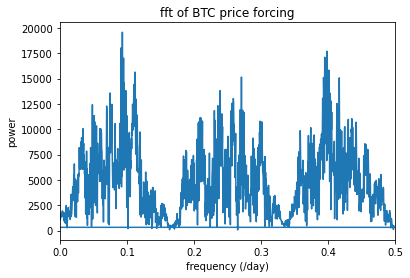

In [91]:
yf = fft(ddP)
xf = list(fftfreq(len(ddP), 1))

plt.plot(xf, np.abs(yf))
plt.title('fft of BTC price forcing')
plt.xlabel('frequency (/day)')
plt.ylabel('power')
plt.xlim(0,0.5)
plt.show()

The price forcing in the frequency domain looks quite promising, however it is important to note that it may be heavily influenced by the smoothing of the original function. To remedy this I will plot a fourier transform of the forcing for increasingly agressive smoothing of the original price. this will allow us to see which frequencies are consistent betwen the different transforms, and see what is due to the data and what is due to the smoothing.   

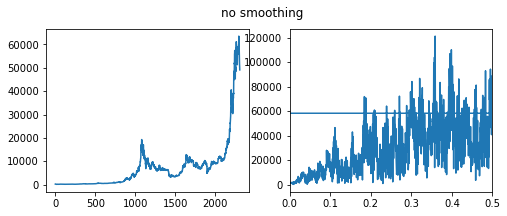

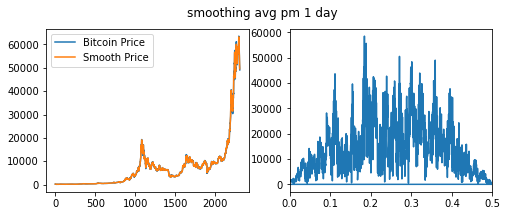

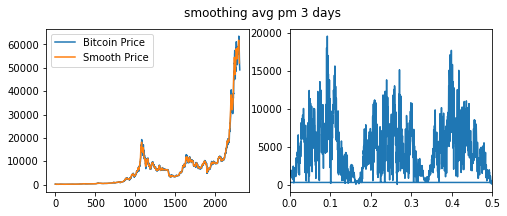

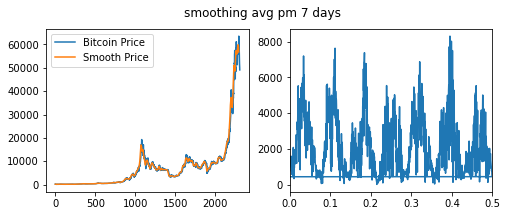

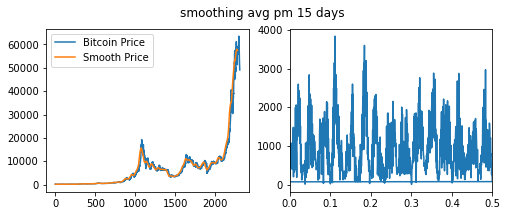

In [92]:
smooth_prices_1, smooth_time_1 = smooth(prices, 1)
smooth_prices_3, smooth_time_3 = smooth(prices, 3)
smooth_prices_7, smooth_time_7 = smooth(prices, 7)
smooth_prices_15, smooth_time_15 = smooth(prices, 15)

dp, dt = derivative(prices, time)
ddp, ddt = derivative(dp, dt)
yf = fft(ddp)
xf = list(fftfreq(len(ddp), 1))

dp1, dt1 = derivative(smooth_prices_1, smooth_time_1)
ddp1, ddt1 = derivative(dp1, dt1)
yf1 = fft(ddp1)
xf1 = list(fftfreq(len(ddp1), 1))

dp3, dt3 = derivative(smooth_prices_3, smooth_time_3)
ddp3, ddt3 = derivative(dp3, dt3)
yf3 = fft(ddp3)
xf3 = list(fftfreq(len(ddp3), 1))

dp7, dt7 = derivative(smooth_prices_7, smooth_time_7)
ddp7, ddt7 = derivative(dp7, dt7)
yf7 = fft(ddp7)
xf7 = list(fftfreq(len(ddp7), 1))

dp15, dt15 = derivative(smooth_prices_15, smooth_time_15)
ddp15, ddt15 = derivative(dp15, dt15)
yf15 = fft(ddp15)
xf15 = list(fftfreq(len(ddp15), 1))

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].plot(time, prices, label='Bitcoin Price')
axs[1].plot(xf, np.abs(yf))
axs[1].set_xlim(0,0.5)
fig.suptitle('no smoothing')
plt.show()

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].plot(time, prices, label='Bitcoin Price')
axs[0].plot(smooth_time_1, smooth_prices_1, label='Smooth Price' )
axs[0].legend()

axs[1].plot(xf1, np.abs(yf1))
axs[1].set_xlim(0,0.5)
fig.suptitle('smoothing avg pm 1 day')
plt.show()

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].plot(time, prices, label='Bitcoin Price')
axs[0].plot(smooth_time_3, smooth_prices_3, label='Smooth Price')
axs[0].legend()

axs[1].plot(xf3, np.abs(yf3))
axs[1].set_xlim(0,0.5)
fig.suptitle('smoothing avg pm 3 days')
plt.show()

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].plot(time, prices, label='Bitcoin Price')
axs[0].plot(smooth_time_7, smooth_prices_7, label='Smooth Price')
axs[0].legend()

axs[1].plot(xf7, np.abs(yf7))
axs[1].set_xlim(0,0.5)
fig.suptitle('smoothing avg pm 7 days')
plt.show()

fig, axs = plt.subplots(1,2, figsize=(8,3))
axs[0].plot(time, prices, label='Bitcoin Price')
axs[0].plot(smooth_time_15, smooth_prices_15, label='Smooth Price')
axs[0].legend()
axs[1].plot(xf15, np.abs(yf15))
axs[1].set_xlim(0,0.5)
fig.suptitle('smoothing avg pm 15 days')
plt.show()


A few of the spikes are consistent throughout the different transforms, for example the one at just after 0, around 0.1 and just before 0.2. This indicatate that these spikes are due to the form of the data and not the smoothing. These particular spikes are also on the lower frequency end, denoting the longer fluctuation periods which I am looking for in trying to determin long-term trends. 

# Next Steps

I will now find the exact frequencies of the biggest common peaks, and use them to reconstruct a market force model, which can then be used to find a bitcoin price model, by taking the second anti derivative. This model will have several parameters which will need to be fit to the data. The parameters will be an amplitude, phase offset for each component, and the two constants from the antiderivatives. I will use a gradient descent algorithm to find the parameters which best fit the data.


First to find the exact values of the common peaks. 